In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from tqdm import tqdm
import random
import os

# --- Configuration ---
N_DEVICES = 30
N_FAILING_DEVICES = 10
TIME_START = datetime(2023, 1, 1)
TIME_END = datetime(2023, 12, 31)
SAMPLING_INTERVAL_HOURS = 1 # Refrigerators report data more frequently
OUTPUT_CSV = 'refrigerator_unified_dataset.csv'

# --- Function to generate data for a single refrigerator ---
def generate_fridge_data(device_id, failure_info):
    timestamps = pd.to_datetime(np.arange(TIME_START, TIME_END, timedelta(hours=SAMPLING_INTERVAL_HOURS)))
    n_samples = len(timestamps)
    df = pd.DataFrame({'timestamp': timestamps, 'device_id': device_id})

    # --- Generate Healthy Features ---
    temp_setpoint = 4.0
    df['temperature_current_c'] = temp_setpoint + np.random.normal(0, 0.2, n_samples)
    df['compressor_on'] = (df['temperature_current_c'] > temp_setpoint).astype(int)
    df['door_open'] = np.random.choice([0, 1], size=n_samples, p=[0.98, 0.02])
    # Simulate a defrost cycle once a day
    df['defrost_cycle_active'] = (np.arange(n_samples) % 24 == 0).astype(int)
    df['ambient_temp_c'] = 22.0 + np.sin(np.arange(n_samples) / (365 * 24) * 2 * np.pi) * 5
    df['filter_life_percent'] = np.linspace(100, 10, n_samples)

    # --- Initialize Labels ---
    df['failure_type'] = 0 # 0 for Healthy
    df['days_until_failure'] = 999.0
    df['is_failing_soon'] = 0

    if failure_info['is_failing']:
        failure_point = int(n_samples * failure_info['failure_point_ratio'])
        degradation_period = int(n_samples * 0.10) # Degradation is often faster in mechanical devices
        degradation_start = failure_point - degradation_period
        degradation_factor = np.linspace(0, 1, n_samples - degradation_start)

        # Apply degradation based on failure type
        if failure_info['failure_type'] == 1: # Compressor Failure
            df.loc[degradation_start:, 'compressor_on'] = 1 # Compressor gets stuck on
            df.loc[degradation_start:, 'temperature_current_c'] += degradation_factor * 8 # Temp rises despite compressor
        elif failure_info['failure_type'] == 2: # Thermostat Failure
            # Temp becomes erratic, causing chaotic compressor cycling
            df.loc[degradation_start:, 'temperature_current_c'] += np.random.normal(0, 3, len(degradation_factor))
            df.loc[degradation_start:, 'compressor_on'] = (df.loc[degradation_start:, 'temperature_current_c'] > temp_setpoint).astype(int)
        elif failure_info['failure_type'] == 3: # Seal Failure
            # Compressor works harder to compensate for leak
            compressor_modifier = (degradation_factor * 0.5) + df.loc[degradation_start:, 'compressor_on']
            df.loc[degradation_start:, 'compressor_on'] = (compressor_modifier > 0.5).astype(int)

        # --- Generate All Three Labels ---
        for i in range(degradation_start, failure_point):
            days_left = (df.loc[failure_point, 'timestamp'] - df.loc[i, 'timestamp']).total_seconds() / (3600 * 24)
            df.loc[i, 'days_until_failure'] = days_left
            df.loc[i, 'failure_type'] = failure_info['failure_type']
            if days_left <= 7:
                df.loc[i, 'is_failing_soon'] = 1

    # Clip values
    df['temperature_current_c'] = df['temperature_current_c'].clip(-10, 30)
    df['filter_life_percent'] = df['filter_life_percent'].clip(0, 100)

    return df

# --- Main Generation Loop (Memory Optimized) ---
if os.path.exists(OUTPUT_CSV):
    os.remove(OUTPUT_CSV)

all_device_ids = [f"fridge_{i:03d}" for i in range(N_DEVICES)]
failing_device_ids = random.sample(all_device_ids, N_FAILING_DEVICES)
failure_types = [1, 2, 3] # 1:Compressor, 2:Thermostat, 3:Seal
failure_infos = {}
for i, device_id in enumerate(failing_device_ids):
    failure_infos[device_id] = {
        "is_failing": True,
        "failure_type": failure_types[i % len(failure_types)],
        "failure_point_ratio": random.uniform(0.8, 0.95)
    }

print(f"Generating new unified dataset '{OUTPUT_CSV}'...")
header_written = False
for i in tqdm(range(N_DEVICES), desc="Simulating Refrigerators"):
    device_id = f"fridge_{i:03d}"
    info = failure_infos.get(device_id, {"is_failing": False})
    device_df = generate_fridge_data(device_id, info)

    device_df.to_csv(OUTPUT_CSV, mode='a', header=not header_written, index=False)
    header_written = True

print(f"\n✅ Unified refrigerator dataset generated successfully!")

Generating new unified dataset 'refrigerator_unified_dataset.csv'...


Simulating Refrigerators: 100%|██████████| 30/30 [00:07<00:00,  4.03it/s]


✅ Unified refrigerator dataset generated successfully!


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
from tqdm import tqdm
import os

# --- Configuration ---
INPUT_CSV = 'refrigerator_unified_dataset.csv'
SEQUENCE_DAYS = 14
SAMPLING_INTERVAL_HOURS = 1
TIMESTEPS_PER_DAY = 24 // SAMPLING_INTERVAL_HOURS
SEQUENCE_TIMESTEPS = SEQUENCE_DAYS * TIMESTEPS_PER_DAY

def prepare_refrigerator_dataset():
    """
    Prepares the unified refrigerator dataset for the multi-task model.
    """
    print("--- Preparing Refrigerator Dataset for Multi-Task Model ---")

    # --- 1. Load Data (Memory Optimized) ---
    print(f"Loading '{INPUT_CSV}'...")
    try:
        dtype_map = {
            'temperature_current_c': 'float32', 'compressor_on': 'int8',
            'door_open': 'int8', 'defrost_cycle_active': 'int8',
            'ambient_temp_c': 'float32', 'filter_life_percent': 'float32',
            'failure_type': 'int8', 'days_until_failure': 'float32', 'is_failing_soon': 'int8'
        }
        df = pd.read_csv(INPUT_CSV, dtype=dtype_map, parse_dates=['timestamp'])
    except FileNotFoundError:
        print(f"Error: The file '{INPUT_CSV}' was not found. Please ensure it was generated correctly.")
        return

    df.sort_values(by=['device_id', 'timestamp'], inplace=True)
    print("Data loaded successfully.")

    # --- 2. Scale Features ---
    feature_columns = [
        'temperature_current_c', 'compressor_on', 'door_open',
        'defrost_cycle_active', 'ambient_temp_c', 'filter_life_percent'
    ]

    print("\nScaling features...")
    scaler = MinMaxScaler()
    df[feature_columns] = scaler.fit_transform(df[feature_columns])
    joblib.dump(scaler, 'refrigerator_multi_task_scaler.joblib')
    print("Scaler saved to 'refrigerator_multi_task_scaler.joblib'.")

    # --- 3. Create Sequences ---
    print(f"\nCreating sequences of {SEQUENCE_TIMESTEPS} timesteps ({SEQUENCE_DAYS} days)...")
    sequences, labels_why, labels_when, labels_if = [], [], [], []

    grouped_data = df.groupby('device_id')

    for _, group in tqdm(grouped_data, desc="Creating Sequences"):
        features = group[feature_columns].values
        label_why = group['failure_type'].values
        label_when = group['days_until_failure'].values
        label_if = group['is_failing_soon'].values

        for i in range(len(features) - SEQUENCE_TIMESTEPS):
            sequences.append(features[i:i + SEQUENCE_TIMESTEPS])
            labels_why.append(label_why[i + SEQUENCE_TIMESTEPS - 1])
            labels_when.append(label_when[i + SEQUENCE_TIMESTEPS - 1])
            labels_if.append(label_if[i + SEQUENCE_TIMESTEPS - 1])

    X = np.array(sequences)
    y_why = np.array(labels_why)
    y_when = np.array(labels_when)
    y_if = np.array(labels_if)

    # --- 4. Save Processed Data ---
    print("\nSaving processed data to .npy files...")
    np.save('refrigerator_sequences_large.npy', X)
    np.save('refrigerator_labels_why_large.npy', y_why)
    np.save('refrigerator_labels_when_large.npy', y_when)
    np.save('refrigerator_labels_if_large.npy', y_if)

    print("\n✅ Data preparation complete. You are now ready to train the multi-task model for the refrigerators.")

if __name__ == "__main__":
    prepare_refrigerator_dataset()

--- Preparing Refrigerator Dataset for Multi-Task Model ---
Loading 'refrigerator_unified_dataset.csv'...
Data loaded successfully.

Scaling features...
Scaler saved to 'refrigerator_multi_task_scaler.joblib'.

Creating sequences of 336 timesteps (14 days)...


Creating Sequences: 100%|██████████| 30/30 [00:00<00:00, 96.44it/s]



Saving processed data to .npy files...

✅ Data preparation complete. You are now ready to train the multi-task model for the refrigerators.


--- Loading Prepared Refrigerator Sequence Data ---
Data loaded successfully. X shape: (252000, 336, 6), y shape: (252000,)
--- Reshaping Data for LightGBM ---
Reshaped X to: (252000, 2016)
--- Splitting Data ---
--- Calculating Class Weights for LightGBM ---
Scale Pos Weight: 149.00

--- Building and Training LightGBM 'Screener' Model ---
[LightGBM] [Info] Number of positive: 1344, number of negative: 200256
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 19.380922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 259056
[LightGBM] [Info] Number of data points in the train set: 201600, number of used features: 2016
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006667 -> initscore=-5.003946
[LightGBM] [Info] Start training from score -5.003946
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[571]	valid_0's binary_logloss: 0.0134672

--- Evaluating Mode

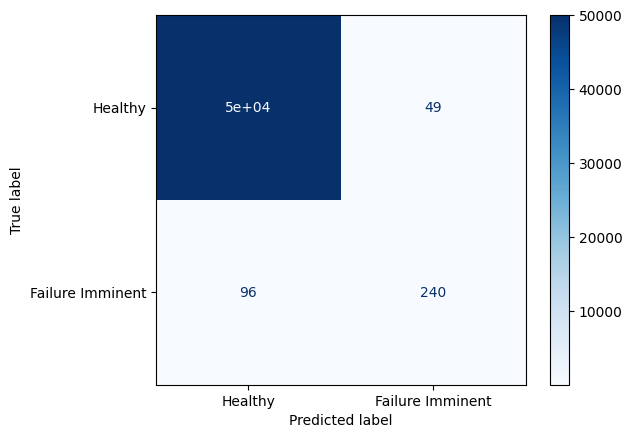


✅ Training complete. Refrigerator 'screener' model saved to 'refrigerator_screener_model.joblib'.


In [3]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
import warnings

warnings.filterwarnings("ignore")

# --- 1. Load Data ---
print("--- Loading Prepared Refrigerator Sequence Data ---")
X_FILE = 'refrigerator_sequences_large.npy'
Y_FILE = 'refrigerator_labels_if_large.npy'

try:
    X = np.load(X_FILE)
    y = np.load(Y_FILE)
    print(f"Data loaded successfully. X shape: {X.shape}, y shape: {y.shape}")
except FileNotFoundError:
    print(f"Error: Make sure '{X_FILE}' and '{Y_FILE}' exist from the data prep step.")
    exit()

# --- 2. Reshape Data for LightGBM ---
print("--- Reshaping Data for LightGBM ---")
n_samples, n_timesteps, n_features = X.shape
X_reshaped = X.reshape(n_samples, n_timesteps * n_features)
print(f"Reshaped X to: {X_reshaped.shape}")

# --- 3. Split Data ---
print("--- Splitting Data ---")
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, random_state=42, stratify=y
)

# --- 4. Handle Class Imbalance ---
print("--- Calculating Class Weights for LightGBM ---")
count_healthy = np.sum(y_train == 0)
count_failing = np.sum(y_train == 1)
scale_pos_weight = count_healthy / count_failing
print(f"Scale Pos Weight: {scale_pos_weight:.2f}")

# --- 5. Build and Train the LightGBM Model ---
print("\n--- Building and Training LightGBM 'Screener' Model ---")
lgbm = lgb.LGBMClassifier(
    objective='binary',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='logloss',
    callbacks=[lgb.early_stopping(10)]
)

# --- 6. Evaluate the Model ---
print("\n--- Evaluating Model Performance ---")
y_pred = lgbm.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Healthy', 'Failure Imminent']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Failure Imminent'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# --- 7. Save the Final Model ---
MODEL_FILENAME = 'refrigerator_screener_model.joblib'
joblib.dump(lgbm, MODEL_FILENAME)
print(f"\n✅ Training complete. Refrigerator 'screener' model saved to '{MODEL_FILENAME}'.")

In [4]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error
import joblib

# --- 1. Load Data ---
print("--- Loading Data for Refrigerator Diagnostician ---")
try:
    X = np.load('refrigerator_sequences_large.npy')
    y_why = np.load('refrigerator_labels_why_large.npy')
    y_when = np.load('refrigerator_labels_when_large.npy')
except FileNotFoundError:
    print("Error: Make sure all 'refrigerator_..._large.npy' files are available.")
    exit()

# --- 2. Isolate ONLY the Failing Data ---
print("--- Isolating Data for Failing Devices Only ---")
failure_indices = np.where(y_why != 0)[0]

X_failing = X[failure_indices]
y_why_failing = y_why[failure_indices]
y_when_failing = y_when[failure_indices]

print(f"Isolated {len(X_failing)} sequences from failing refrigerators.")

# --- 3. Reshape Data for LightGBM ---
n_samples, n_timesteps, n_features = X_failing.shape
X_reshaped = X_failing.reshape(n_samples, n_timesteps * n_features)

# --- 4. Split Data ---
X_train, X_test, y_train_why, y_test_why, y_train_when, y_test_when = train_test_split(
    X_reshaped, y_why_failing, y_when_failing, test_size=0.2, random_state=42
)

# --- 5. Train the "WHY" (Classifier) Model ---
print("\n--- Training the 'WHY' (Classifier) Model ---")
failure_map = {1: "Compressor Failure", 2: "Thermostat Failure", 3: "Seal Failure"}

lgbm_why = lgb.LGBMClassifier(objective='multiclass', random_state=42)
lgbm_why.fit(X_train, y_train_why)

# --- 6. Train the "WHEN" (Regressor) Model ---
print("\n--- Training the 'WHEN' (Regressor) Model ---")
lgbm_when = lgb.LGBMRegressor(objective='regression_l1', random_state=42) # L1 is robust
lgbm_when.fit(X_train, y_train_when)

# --- 7. Evaluate the Models ---
print("\n--- Evaluating Diagnostician Models ---")

# Evaluate "WHY" model
y_pred_why = lgbm_why.predict(X_test)
print("\n'WHY' Model Classification Report:")
print(classification_report(y_test_why, y_pred_why, target_names=failure_map.values()))

# Evaluate "WHEN" model
y_pred_when = lgbm_when.predict(X_test)
mae = mean_absolute_error(y_test_when, y_pred_when)
print(f"\n'WHEN' Model Mean Absolute Error: {mae:.2f} days")
print("(This means on average, the prediction for days-to-failure is off by this amount)")

# --- 8. Save the Final Models ---
joblib.dump(lgbm_why, 'refrigerator_diagnostician_why.joblib')
joblib.dump(lgbm_when, 'refrigerator_diagnostician_when.joblib')
print("\n✅ Training complete. Final refrigerator diagnostician models have been saved.")

--- Loading Data for Refrigerator Diagnostician ---
--- Isolating Data for Failing Devices Only ---
Isolated 8730 sequences from failing refrigerators.

--- Training the 'WHY' (Classifier) Model ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.471251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 259056
[LightGBM] [Info] Number of data points in the train set: 6984, number of used features: 2016
[LightGBM] [Info] Start training from score -0.911506
[LightGBM] [Info] Start training from score -1.190321
[LightGBM] [Info] Start training from score -1.224320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos